This script was developed by Amy McKeown-Green at Stanford University, Dionne lab Nov 20-27, 2023.
It is primarily a python version of the BHMIE code from 'Absorption and Scattering of Light by Small Particles' by
BOHREN and HUFFMAN, Wiley Professional Paperback Edition Published 1998. It has key differences from BHMIE that take 
advantage of the speed and storage capacity of modern day computers that allows for parameters to be stored from 
each iteration. 

It allows for the calculation of the Stokes parameters from the scattering matrix for a user-determined set of 
scattering angles along with the scattering, absorption, and extinction cross sections. The code often normalizes these
by $\pi r^2$ to obtain efficiencies. 

While this code is not the most efficient or well-designed, it is intended to strongly mirror the underlying mathematics and be easily understandable. To that end, I will try to interdisperse the mathematical basis for each function and leave some comments in the code. 



In [2]:
import numpy as np 
import matplotlib.pyplot as plt

$x = \frac{2\pi N r}{\lambda}$ represents a size parameter used to determine max indices for interation. 

In [3]:
def calculate_x(medium_n, sphere_n, radius, wavelength, num_angles):
    ''' Input parameters: medium_n, sphere_n are the refractive indices of the sphere and surrounding medium. They can be complex numbers
    radius and wavelength are both real doubles 
    num_angles is a numpy array that is user-defined and determines the different scattering locations used to calculate 
    the stokes parameters
    
    !!!!!!BOTH wavelength and radius have to me in the SAME units!!!!!!!!!
    
    Output parameters: x is the relative size parameter, N is the relative refractive index, NMX is the max index'''
  
    relative_N = sphere_n/medium_n # this should be a complex number 
    x = 2*np.pi*medium_n*radius*(1/wavelength)
    #print(x)
      
    stop_indx = int(abs(x+(4*x**(1/3))+2))
    mx = relative_N*x
    NMX = max(stop_indx, int(abs(mx)))+15

    return x, relative_N, NMX

$\pi_n$ and $\tau_n$ are angle-dependent functions that are either directly proportional to (or proportional to the derivative) of the associated Legendre functions of the first kind which arise during the expansion of a plance wave in vector spherical harmonics. $\pi_n$ and $\tau_n$ have the following recurance relations.

$$ \pi_n = \frac{P_n^1}{sin\theta} = \frac{2n-1}{n-1}\mu \pi_{n-1} - \frac{n}{n-1} \pi_{n-2}$$

$$ \tau_n =  \dfrac{dP_n^1}{d\theta} = n \mu \pi_n - (n+1)\pi_{n-1} $$

Here $\mu = cos\theta$ and $\pi_0 = 0$, $\pi_1 = 1$. 


In [4]:
def pi_n_calc(num_angles, NMX):
    ''' 
    Input parameters: num_angles is a user-defined array, NMX is the max index of integration
    Output parameters: pi_n_store is an i x j array where the ith row corresponds to a given scattering angle 
    and the jth column corresponds to the index "n" 
    '''
    
    #each angle corresponds to a row and each column corresponds to a value of n
    delta_angle = (np.pi/2)*(1/(num_angles-1))
    angle_holder = np.arange(0,num_angles)
    angles = angle_holder*delta_angle
    angles.shape = (len(angles),1)
    
    pi_n_store = np.zeros([num_angles, NMX+1])
    pi_n_store.shape = (num_angles,NMX+1)
    tau_n_store = np.zeros([num_angles, NMX+1])
    #print(angles, 'angles')
    
    for n in range(0,NMX+1):
        if n == 0:
            pi_n = np.zeros(num_angles)
        elif n == 1:
            pi_n = np.zeros(num_angles) + 1
        else:
            pi_n_m_1 = pi_n_store[:,n-1]
            pi_n_m_1.shape = (len( pi_n_m_1),1)
            pi_n_m_2 = pi_n_store[:,n-2]
            pi_n_m_2.shape = (len( pi_n_m_2),1)
            
            pi_n = (2*n-1)/(n-1) * np.cos(angles) *pi_n_m_1 - ((n)/(n-1)) * pi_n_m_2
            pi_n.shape = (num_angles)
        
        pi_n_store[:,n] = pi_n[:]
    #print('dimensions','pi_n_store',  np.size(pi_n_store[:,0]),np.size(pi_n_store[0,:]))
        
    return pi_n_store


In [5]:
#now use this to calculate tau
''' Input parameters: pi_n_store is an i x j array where the ith row corresponds to a given scattering angle 
    and the jth column corresponds to the index "n" and num_angles is a user defined array
    
    Output parameters: tau_n_store is an i x j array where the ith row corresponds to a given scattering angle 
    and the jth column corresponds to the index "n" 
    '''

def tau_n_calc(pi_n_store, num_angles):
       
    delta_angle = (np.pi/2)*(1/(num_angles-1))
    angle_holder = np.arange(0,num_angles)
    angles = angle_holder*delta_angle
    angles.shape = (len(angles),1)
    #print(num_angles)
    pi_n = pi_n_store
    pi_n_m_1 = np.zeros([num_angles,len(pi_n[1,:])])
    #print('dimensions','pi_n_store',  np.size(pi_n_m_1[:,0]),np.size(pi_n_m_1[0,:]))
    pi_n_m_1[:,1:len(pi_n[1,:])] = pi_n[:,0:len(pi_n[1,:])-1]
    
    #print(pi_n_m_1,'pi_n_m_1')
    
    n = np.arange(0,np.size(pi_n_store[1,:]))
    n.shape = (1,len(n))
    tau_n_store = n*np.cos(angles)*pi_n - (n+1)*pi_n_m_1 
       
    return tau_n_store



At the time BHMIE was developed (and possibly still?), roundoff errors due to the calculation of arbitrarily ordered Bessel functions presented a challenged to the computation of scattering coefficients. The solution presented by BOHREN and HUFFMAN is to use the logarithmic derivative 

$$ D_n(\rho) = \dfrac{d}{d\rho}ln(\psi_n(\rho)) $$

and has the recurance relation $D_{n-1} = \frac{n}{\rho} - \frac{1}{D_n +n/\rho}$ and $D_{NMX} = 0$

Note that we observe $\rho = x$ and $\psi_n$ in the initial definition of $D_n$. These represents the Riccati-Vessel function $\psi_n(\rho) = \rho j_n(\rho)$ with the following recursion relation 

$$\psi_{n+1}(x) = \frac{2n+1}{x}\psi_n(x) - \psi_{n-1}(x) $$ 

where 

$$ \psi_{-1}(x) = cos(x),\ \psi_0(x)= sin(x)$$ 
$$ \chi_{-1}(x) = -sin(x),\ \chi_0(x) = cos(x)$$ 

Here, $\xi = \psi_n - i\chi_n$ and follows the same recursion relation as $\psi_n(x)$. 

These bessel-related functions will be used to calculate the $a_n$ and $b_n$ coefficients which describe the expansion of the plane wave fector in vector spherical harmonics and thus can be used to determine scattering coefficients later on. 

In [6]:
def log_derivative_D_J(NMX,relative_N,x):
    y = relative_N*x
    D_store = np.zeros(NMX+1)+1j*np.zeros(NMX+1)
    D_store[NMX] = 0+1j*0
    for n in range(0,NMX):
        D_store[NMX-n-1] = (NMX-n)/y - (1/((D_store[NMX-n]) + (NMX-n)/y))
       # print(D_store)
    return D_store

In [7]:
def psi_eta_generate(x, NMX):
    
    psi_store = np.zeros(NMX+1)
    chi_store = np.zeros(NMX+1)
    eta_store =np.zeros(NMX+1, dtype=complex)
    
    psi_m1 = np.cos(x)
    psi_0 = np.sin(x)
    
    chi_m1 = -1*np.sin(x)
    chi_0 = np.cos(x)
    
    eta_m1 = psi_m1-1j*chi_m1
    eta_0 = psi_0 - 1j*chi_0
    
    psi_store[0] = psi_0
    chi_store[0] = chi_0
    eta_store[0] = eta_0
    
    for n in range(0,NMX): 
        if n == 0:
            psi_store[n+1] = ((2*n+1)/x)*psi_store[n]-psi_m1
            chi_store[n+1] = ((2*n+1)/x)*chi_store[n]-chi_m1
            
        else: 
            psi_store[n+1] = ((2*n+1)/x)*psi_store[n] - psi_store[n-1]
            chi_store[n+1] = ((2*n+1)/x)*chi_store[n] - chi_store[n-1]
            
            
        eta_store[n+1] = psi_store[n+1]-1j*chi_store[n+1]
        #print(eta_store[n+1])
            
    return psi_store,  eta_store
 
    
    

Now, we have what we need to calculate the scattering coefficients for a sphere ($a_n$ and $b_n$)

$$ a_n = \frac{[D_n(mx)/m + n/x]\psi_n(x) - \psi_{n-1}(x)}{[D_n(mx)/m + n/x]\xi_n(x) - \xi_{n-1}(x)}$$

$$ b_n = \frac{[mD_n(mx) + n/x]\psi_n(x) - \psi_{n-1}(x)}{[mD_n(mx) + n/x]\xi_n(x) - \xi_{n-1}(x)}$$

In [8]:
def coefficient_an_bn(x, NMX, relative_N):
    
    #call previous functions
    psi_store, eta_store = psi_eta_generate(x, NMX)
    D_store = log_derivative_D_J(NMX,relative_N,x)
    
    psi_m1 = np.cos(x)    
    chi_m1 = -1*np.sin(x)
    eta_m1 = psi_m1 - 1j*chi_m1
    
    
    an_store = np.zeros(NMX+1, dtype=complex)
    bn_store = np.zeros(NMX+1,dtype=complex)
    
    for n in range(0,NMX+1):
   
        if n == 0:            
            an_numer = (D_store[n]/relative_N + n/x)*psi_store[n] - psi_m1
            an_denom = (D_store[n]/relative_N + n/x)*eta_store[n] - eta_m1
            an_store[n] = an_numer/an_denom
            
            bn_numer = (D_store[n]*relative_N + n/x)*psi_store[n] - psi_m1
            bn_denom = (D_store[n]*relative_N + n/x)*eta_store[n] - eta_m1
            bn_store[n] = bn_numer/bn_denom

        else: 
            an_numer = (D_store[n]/relative_N + n/x)*psi_store[n] - psi_store[n-1]
            an_denom = (D_store[n]/relative_N + n/x)*eta_store[n] - eta_store[n-1]
            an_store[n] = an_numer/an_denom
            
            bn_numer = (D_store[n]*relative_N + n/x)*psi_store[n] - psi_store[n-1]
            bn_denom = (D_store[n]*relative_N + n/x)*eta_store[n] - eta_store[n-1]
            bn_store[n] = bn_numer/bn_denom   
    
    return an_store, bn_store



From here, we can now calculate the scattering and extinction cross sections

$$C_{sca} = \frac{W_s}{I_i} = \frac{2\pi}{k^2} \sum_{n=1}^\infty(2n+1)(|a_n|^2 + |b_n|^2) $$

$$C_{ext} = \frac{W_ext}{I_i} = \frac{2\pi}{k^2} \sum_{n=1}^\infty(2n+1)Re\{a_n + b_n\} $$

The absorption cross section can then be calculated as C_{abs} = $C_{ext} - C_{sca}$



In [9]:
def cross_section(x,NMX, relative_N, num_angles): 
    #note that Qext = Cext/(a^2 pi)
    an_store, bn_store = coefficient_an_bn(x, NMX, relative_N)
    Q_sca = 0
    Q_ext = 0    
    for n in range(1,NMX+1):
        Q_sca += ((2*n+1)*(abs(an_store[n])*abs(an_store[n]) + abs(bn_store[n])*abs(bn_store[n])))
        Q_ext += (2*n+1)*np.real(an_store[n]+bn_store[n])
        #print('square',abs(an_store[n])**2, 'real', np.real(an_store[n]) )
        #print(C_sca*(2/(x**2)),C_ext*(2/(x**2)))
    Q_sca *= (2/(x**2))
    Q_ext *= (2/(x**2))
    
    stokes_parameters = stokes_param(NMX, num_angles,an_store, bn_store)
    
    S1 = stokes_parameters.get('S1')
    
    Q_back = (4/(x**2))*abs(S1[-1])*abs(S1[-1])
        
    return Q_sca, Q_ext, Q_back, stokes_parameters


To obtain more information, we can also calculate the different stokes parameters. 

$$ S_1 \sum_n^{NMX} \frac{2n+1}{n(n+1)} (a_n\pi_n + b_n\tau_n)$$

$$ S_1 \sum_n^{NMX} \frac{2n+1}{n(n+1)} (a_n\tau_n + b_n\pi_n)$$

such that 

$$ \begin{bmatrix}
           E_{||s} \\
           E_{\perp s} \\
         \end{bmatrix}= \frac{e^{ik(r-z)}}{-ikr} \begin{bmatrix}
           S_2 & 0 \\
           0  & S_1\\
         \end{bmatrix} \begin{bmatrix}
           E_{||i} \\
           E_{\perp i} \\
         \end{bmatrix}$$
         
The stokes parameters can then be calculated from $S_1$ and $S_2$ for each angle, yielding $S_{11}$, $S_{12}$, $S_{33}$,  and $S_{34}$ respectively. The degree of polarization P is also calculated as $P = -\frac{S_{12}}{S_{11}}$

In [10]:
def stokes_param(NMX, num_angles,an_store, bn_store):   
    
    pi_n_store =  pi_n_calc(num_angles, NMX)
    tau_n_store = tau_n_calc(pi_n_store, num_angles)
    
    
    full_180_num_angles = 2*num_angles - 1
    end = full_180_num_angles
    #print(full_180_num_angles)
    S1 = np.zeros([full_180_num_angles], dtype = complex)
    S2 = np.zeros([full_180_num_angles], dtype = complex)
    
    for n in range (1,NMX+1):
        fn = ((2*n+1)/(n*(n+1)))
        S1[0:num_angles] = S1[0:num_angles]+ fn*(an_store[n]*pi_n_store[:,n]+bn_store[n]*tau_n_store[:,n])
        S2[0:num_angles] = S2[0:num_angles]+ fn*(an_store[n]*tau_n_store[:,n]+bn_store[n]*pi_n_store[:,n])
        T = (-1)**n
        P = (-1)**(n-1)
        S1[num_angles:end] =  S1[num_angles:end] + np.flip(fn*(an_store[n]*pi_n_store[0:num_angles-1,n]*P + bn_store[n]*tau_n_store[0:num_angles-1,n]*T))
        S2[num_angles:end] = S2[num_angles:end] + np.flip(fn*(an_store[n]*tau_n_store[0:num_angles-1,n]*T + bn_store[n]*pi_n_store[0:num_angles-1,n]*P))    
    
    
    
    S11_norm = 0.5*(abs(S2[0])**2 + abs(S1[0])**2)    
    #S11_norm = 0.5*(abs(S2)**2 + abs(S1)**2)
    S11 = 0.5*abs(S2)*abs(S2)
    S11 = S11 + 0.5*(abs(S1)*abs(S1))
        
    S12 = 0.5*abs(S2)*abs(S2)
    S12 = S12 - 0.5*abs(S1)*abs(S1)
        
    Pol = -S12/S11 
    S33 = np.real(S2*np.conjugate(S1))
    S33 = S33/S11
    S34 = np.imag(S2*np.conjugate(S1))
    S34 = S34/S11
    S11 =S11/S11_norm
    
    delta_angle = (np.pi/2)*(1/(num_angles-1))
    angle_holder = np.arange(0,num_angles*2-1)
    ang = angle_holder*delta_angle*57.2958
    
    #print(S11)
    stokes_parameters = {'S1': S1, 'S2':S2, 'S11':S11, 'S12':S12, 'Pol':Pol, 'S33':S33, 'S34':S34, 'ang':ang}
    
    
    return stokes_parameters

num_angles = 11
radius = 0.525
wavelength = 0.6328
medium_n = 1
sphere_n = relative_N = 1.55 +1j*1E-8
x, relative_N, NMX = calculate_x(medium_n, sphere_n, radius, wavelength, num_angles)
#print(relative_N)
Q_sca, Q_ext, Q_back, stokes_parameters = cross_section(x, NMX, relative_N, num_angles)

#print(Q_sca, Q_ext, Q_back, Q_ext>Q_sca)


These next few functions are designed to take a .csv file input of refractive index information from this site: https://refractiveindex.info/?shelf=main&book=Au&page=Magnozzi-25C

With two columns, one wavelength and the other either n (first half) and then k (second half). 

There will be a pop up so you can select the file from your computer (it uses tkinter).

In [11]:
# Import the required Libraries
from tkinter import *
from tkinter import filedialog
from tkinter.filedialog import askopenfile
import os
import pandas as pd

# Create an instance of tkinter frame

file = filedialog.askopenfile(mode='r')
filepath = os.path.abspath(file.name)


In [12]:
df = pd.read_table(filepath, delimiter = ',')
numpy_array = np.asarray(df)



first_half_n = numpy_array[0:int(len(numpy_array)/2)]
second_half_k = numpy_array[int(len(numpy_array)/2)+1:len(numpy_array)+1]
real_index_n= first_half_n.astype(float)
complex_index_k = second_half_k.astype(float)

wavelength = real_index_n[:,0]
wavelength_2 = complex_index_k[:,0]

#print(wavelength == wavelength_2)
print(len(real_index_n), len(complex_index_k))

601 601


In [13]:

def extinction_plot(medium_n_range, sphere_n_range, radius, wavelength_range, num_angles):
    #right now assume micrometers for wavelength and radius 
    Q_ext_store = np.zeros(len(wavelength_range))
    
    for wavelength_indx in range(0,len(wavelength_range)):
        
        wavelength = wavelength_range[wavelength_indx] #in micrometers 
        sphere_n = sphere_n_range[wavelength_indx]
        medium_n = medium_n_range[wavelength_indx]
        #print(wavelength, sphere_n, medium_n)
        
        x, relative_N, NMX = calculate_x(medium_n, sphere_n, radius, wavelength, num_angles)
        Q_sca, Q_ext, Q_back, stokes_parameters = cross_section(x, NMX, relative_N, num_angles)
        
        Q_ext_store[wavelength_indx] = Q_ext       
        
    
    return Q_ext_store



In [14]:
medium_n_range = real_index_n[:,1]*0 + 1
sphere_n_range = real_index_n[:,1] + 1j*complex_index_k[:,1]
wavelength_range = wavelength 
energy_range_eV = (6.626E-34*2.998E8)/(wavelength_range*1E-6*1.6022E-19)
#print(sphere_n_range)
radius = 0.01 # in micron 
num_angles = 11

This function plots the extinction efficiency for particles of different wavelengths. 

In [15]:
radii = np.arange(0.005,0.05,0.005) #in micron
num_radii = len(radii)
Q_ext_store = np.zeros([num_radii,len(wavelength)])

for radii_indx in range(0,num_radii):
    radius = radii[radii_indx]
    Q_ext_store[radii_indx,:]=extinction_plot(medium_n_range, sphere_n_range, radius, wavelength_range, num_angles)

3.6565062528368673


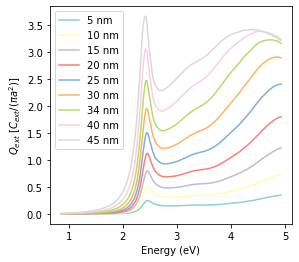

In [16]:
fig = plt.figure()
# to change default color cycle
colormap = plt.cm.viridis
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set3.colors)
ax1 = fig.add_subplot(111)
for radii_indx in range(0,num_radii):
    plt.plot(energy_range_eV, Q_ext_store[radii_indx,:], label = str(int(radii[radii_indx]*1000)) + ' nm')
    #plt.plot(wavelength_range, Q_ext_store[radii_indx,:]/np.max(Q_ext_store[radii_indx,100:-1]))
    
plt.xlabel('Energy (eV)')
plt.ylabel(r'$Q_{ext}\ [C_{ext}/(\pi a^2)]$')


ax1.set_aspect('equal')
plt.legend()

print(np.max(Q_ext_store[radii_indx,:]))
plt.savefig("multiple_radii.pdf")
